In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import cv2
from matplotlib.patches import Circle
import matplotlib
from matplotlib import rcParams
import os

# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
rcParams['axes.unicode_minus'] = False

class CHOMP:
    def __init__(self, start, goal, obstacles, num_waypoints=50, lambda_obs=10.0, 
                 smoothness_cost=0.1, learning_rate=0.01, max_iterations=1000):
        """
        CHOMP算法实现
        
        参数:
        start: 起点坐标 [x, y]
        goal: 终点坐标 [x, y] 
        obstacles: 障碍物列表，每个障碍物为[x, y, radius]
        num_waypoints: 路径点数量
        lambda_obs: 障碍物项权重
        smoothness_cost: 平滑度代价权重
        learning_rate: 学习率
        max_iterations: 最大迭代次数
        """
        self.start = np.array(start, dtype=np.float64)
        self.goal = np.array(goal, dtype=np.float64)
        self.obstacles = np.array(obstacles, dtype=np.float64)
        self.num_waypoints = num_waypoints
        self.lambda_obs = lambda_obs
        self.smoothness_cost = smoothness_cost
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        
        # 初始化轨迹 (直线)
        self.trajectory = self.initialize_trajectory()
        
        # 预计算平滑度矩阵
        self.A = self.compute_smoothness_matrix()
        self.A_inv = np.linalg.pinv(self.A + 1e-8 * np.eye(self.num_waypoints))  # 添加正则化
        
    def initialize_trajectory(self):
        """初始化轨迹为起点到终点的直线"""
        trajectory = np.zeros((self.num_waypoints, 2), dtype=np.float64)
        for i in range(self.num_waypoints):
            alpha = i / (self.num_waypoints - 1)
            trajectory[i] = (1 - alpha) * self.start + alpha * self.goal
        return trajectory
    
    def compute_smoothness_matrix(self):
        """计算平滑度矩阵 (基于加速度)"""
        A = np.zeros((self.num_waypoints, self.num_waypoints), dtype=np.float64)
        
        # 构建二阶差分矩阵 (加速度近似)
        for i in range(1, self.num_waypoints - 1):
            A[i, i-1] = 1
            A[i, i] = -2
            A[i, i+1] = 1
            
        # 边界条件 - 使用更温和的边界处理
        A[0, 0] = 0.1
        A[-1, -1] = 0.1
        
        return A
    
    def obstacle_cost_and_gradient(self, point):
        """计算单个点的障碍物代价和梯度"""
        total_cost = 0.0
        gradient = np.zeros(2, dtype=np.float64)
        
        for obstacle in self.obstacles:
            obs_pos = obstacle[:2]
            obs_radius = obstacle[2]
            
            # 计算到障碍物的距离
            diff = point - obs_pos
            distance = np.linalg.norm(diff)
            
            if distance < 1e-6:  # 避免除零
                distance = 1e-6
                diff = np.array([1e-6, 1e-6])
            
            # 安全距离 (障碍物半径 + 机器人半径)
            safe_distance = obs_radius + 0.3
            
            if distance < safe_distance:
                # 使用更平滑的障碍物代价函数
                # 当distance接近safe_distance时，代价平滑过渡到0
                cost = 0.5 * (safe_distance - distance) ** 2
                total_cost += cost
                
                # 障碍物梯度
                grad = -(safe_distance - distance) * (diff / distance)
                gradient += grad
        
        return total_cost, gradient
    
    def compute_costs_and_gradients(self):
        """计算总代价和梯度"""
        smoothness_cost = 0.0
        obstacle_cost = 0.0
        
        smoothness_grad = np.zeros_like(self.trajectory, dtype=np.float64)
        obstacle_grad = np.zeros_like(self.trajectory, dtype=np.float64)
        
        # 平滑度代价和梯度 - 添加数值稳定性
        trajectory_sq = self.trajectory.T @ self.A.T @ self.A @ self.trajectory
        smoothness_cost = 0.5 * np.trace(np.clip(trajectory_sq, -1e10, 1e10))
        
        for i in range(2):  # x和y维度
            grad = self.A.T @ self.A @ self.trajectory[:, i]
            smoothness_grad[:, i] = np.clip(grad, -1e6, 1e6)
        
        # 障碍物代价和梯度
        for i in range(self.num_waypoints):
            cost, grad = self.obstacle_cost_and_gradient(self.trajectory[i])
            obstacle_cost += cost
            obstacle_grad[i] = np.clip(grad, -1e6, 1e6)
        
        # 计算总代价和梯度，添加数值稳定性
        total_cost = (self.smoothness_cost * smoothness_cost + 
                     self.lambda_obs * obstacle_cost)
        
        total_grad = (self.smoothness_cost * smoothness_grad + 
                     self.lambda_obs * obstacle_grad)
        
        # 梯度裁剪，防止梯度爆炸
        grad_norm = np.linalg.norm(total_grad)
        if grad_norm > 100.0:
            total_grad = total_grad / grad_norm * 100.0
        
        return total_cost, total_grad, smoothness_cost, obstacle_cost
    
    def optimize(self):
        """执行优化"""
        costs = []
        smoothness_costs = []
        obstacle_costs = []
        
        print("Starting CHOMP optimization...")
        
        best_trajectory = self.trajectory.copy()
        best_cost = float('inf')
        
        for iteration in range(self.max_iterations):
            # 计算代价和梯度
            total_cost, total_grad, smooth_cost, obs_cost = self.compute_costs_and_gradients()
            
            costs.append(total_cost)
            smoothness_costs.append(smooth_cost)
            obstacle_costs.append(obs_cost)
            
            # 保存最佳轨迹
            if total_cost < best_cost:
                best_cost = total_cost
                best_trajectory = self.trajectory.copy()
            
            # 使用自然梯度下降 (预条件梯度)
            update = self.A_inv @ total_grad
            
            # 梯度裁剪
            update_norm = np.linalg.norm(update)
            if update_norm > 10.0:
                update = update / update_norm * 10.0
            
            # 自适应学习率
            current_learning_rate = self.learning_rate * (0.1 + 0.9 * np.exp(-iteration / 100))
            
            # 更新轨迹 (保持起点和终点固定)
            self.trajectory -= current_learning_rate * update
            self.trajectory[0] = self.start  # 固定起点
            self.trajectory[-1] = self.goal  # 固定终点
            
            # 打印进度
            if iteration % 50 == 0:
                print(f"Iteration {iteration}: Total Cost = {total_cost:.4f}, "
                      f"Smoothness Cost = {smooth_cost:.4f}, Obstacle Cost = {obs_cost:.4f}")
            
            # 收敛检查
            if iteration > 10 and abs(costs[-1] - costs[-2]) < 1e-6:
                print(f"Converged at iteration {iteration}")
                break
        
        # 恢复最佳轨迹
        self.trajectory = best_trajectory
        
        return costs, smoothness_costs, obstacle_costs
    
    def plot_and_save_results(self, costs, smoothness_costs, obstacle_costs, save_dir="./results"):
        """绘制并保存优化结果到四个独立的图片"""
        # 创建保存目录
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        # 1. 轨迹图
        fig1, ax1 = plt.figure(figsize=(10, 8)), plt.gca()
        ax1.plot(self.trajectory[:, 0], self.trajectory[:, 1], 'b-', linewidth=2, label='Optimized Trajectory')
        ax1.plot([self.start[0]], [self.start[1]], 'go', markersize=10, label='Start')
        ax1.plot([self.goal[0]], [self.goal[1]], 'ro', markersize=10, label='Goal')
        
        # 绘制初始轨迹
        initial_trajectory = self.initialize_trajectory()
        ax1.plot(initial_trajectory[:, 0], initial_trajectory[:, 1], 'k--', 
                 linewidth=1, alpha=0.5, label='Initial Trajectory')
        
        # 绘制障碍物
        for obstacle in self.obstacles:
            circle = Circle(obstacle[:2], obstacle[2], fill=True, color='red', alpha=0.3)
            ax1.add_patch(circle)
            # 安全距离圆
            safe_circle = Circle(obstacle[:2], obstacle[2] + 0.3, fill=False, 
                               color='red', linestyle='--', alpha=0.5)
            ax1.add_patch(safe_circle)
        
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_title('Trajectory Planning Result')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.axis('equal')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "trajectory.png"), dpi=300, bbox_inches='tight')
        plt.close(fig1)
        
        # 2. 总代价曲线图
        fig2, ax2 = plt.figure(figsize=(10, 8)), plt.gca()
        ax2.plot(costs, 'r-', linewidth=2, label='Total Cost')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Cost')
        ax2.set_title('Total Cost Convergence')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_yscale('log')  # 使用对数坐标
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "total_cost.png"), dpi=300, bbox_inches='tight')
        plt.close(fig2)
        
        # 3. 各分量代价曲线图
        fig3, ax3 = plt.figure(figsize=(10, 8)), plt.gca()
        ax3.plot(smoothness_costs, 'b-', linewidth=2, label='Smoothness Cost')
        ax3.plot(obstacle_costs, 'g-', linewidth=2, label='Obstacle Cost')
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('Cost')
        ax3.set_title('Cost Components')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.set_yscale('log')  # 使用对数坐标
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "cost_components.png"), dpi=300, bbox_inches='tight')
        plt.close(fig3)
        
        # 4. 轨迹曲率图
        fig4, ax4 = plt.figure(figsize=(10, 8)), plt.gca()
        curvature = self.compute_curvature()
        ax4.plot(range(len(curvature)), curvature, 'm-', linewidth=2)
        ax4.set_xlabel('Waypoint Index')
        ax4.set_ylabel('Curvature')
        ax4.set_title('Trajectory Curvature')
        ax4.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "curvature.png"), dpi=300, bbox_inches='tight')
        plt.close(fig4)
        
        print(f"图片已保存到 {save_dir} 目录")
        
    def plot_results(self, costs, smoothness_costs, obstacle_costs):
        """绘制优化结果（保持原功能）"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 轨迹图
        axes[0, 0].plot(self.trajectory[:, 0], self.trajectory[:, 1], 'b-', linewidth=2, label='Optimized Trajectory')
        axes[0, 0].plot([self.start[0]], [self.start[1]], 'go', markersize=10, label='Start')
        axes[0, 0].plot([self.goal[0]], [self.goal[1]], 'ro', markersize=10, label='Goal')
        
        # 绘制初始轨迹
        initial_trajectory = self.initialize_trajectory()
        axes[0, 0].plot(initial_trajectory[:, 0], initial_trajectory[:, 1], 'k--', 
                       linewidth=1, alpha=0.5, label='Initial Trajectory')
        
        # 绘制障碍物
        for obstacle in self.obstacles:
            circle = Circle(obstacle[:2], obstacle[2], fill=True, color='red', alpha=0.3)
            axes[0, 0].add_patch(circle)
            # 安全距离圆
            safe_circle = Circle(obstacle[:2], obstacle[2] + 0.3, fill=False, 
                               color='red', linestyle='--', alpha=0.5)
            axes[0, 0].add_patch(safe_circle)
        
        axes[0, 0].set_xlabel('X')
        axes[0, 0].set_ylabel('Y')
        axes[0, 0].set_title('Trajectory Planning Result')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].axis('equal')
        
        # 总代价曲线
        axes[0, 1].plot(costs, 'r-', linewidth=2, label='Total Cost')
        axes[0, 1].set_xlabel('Iteration')
        axes[0, 1].set_ylabel('Cost')
        axes[0, 1].set_title('Total Cost Convergence')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_yscale('log')  # 使用对数坐标
        
        # 各分量代价曲线
        axes[1, 0].plot(smoothness_costs, 'b-', linewidth=2, label='Smoothness Cost')
        axes[1, 0].plot(obstacle_costs, 'g-', linewidth=2, label='Obstacle Cost')
        axes[1, 0].set_xlabel('Iteration')
        axes[1, 0].set_ylabel('Cost')
        axes[1, 0].set_title('Cost Components')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_yscale('log')  # 使用对数坐标
        
        # 轨迹曲率图
        curvature = self.compute_curvature()
        axes[1, 1].plot(range(len(curvature)), curvature, 'm-', linewidth=2)
        axes[1, 1].set_xlabel('Waypoint Index')
        axes[1, 1].set_ylabel('Curvature')
        axes[1, 1].set_title('Trajectory Curvature')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def compute_curvature(self):
        """计算轨迹曲率"""
        curvature = []
        for i in range(1, len(self.trajectory) - 1):
            dx = self.trajectory[i, 0] - self.trajectory[i-1, 0]
            dy = self.trajectory[i, 1] - self.trajectory[i-1, 1]
            ddx = self.trajectory[i+1, 0] - 2*self.trajectory[i, 0] + self.trajectory[i-1, 0]
            ddy = self.trajectory[i+1, 1] - 2*self.trajectory[i, 1] + self.trajectory[i-1, 1]
            
            denom = (dx**2 + dy**2)**1.5
            if denom > 1e-6:
                k = abs(dx*ddy - dy*ddx) / denom
            else:
                k = 0
            curvature.append(k)
        
        # 添加边界点
        curvature = [0] + curvature + [0]
        return curvature
    
    def save_trajectory_data(self, filename="trajectory_data.txt"):
        """保存轨迹数据到文本文件"""
        with open(filename, 'w') as f:
            f.write("# CHOMP轨迹数据\n")
            f.write(f"# 起点: {self.start}\n")
            f.write(f"# 终点: {self.goal}\n")
            f.write(f"# 路径点数量: {self.num_waypoints}\n")
            f.write("# X, Y\n")
            for i, point in enumerate(self.trajectory):
                f.write(f"{point[0]:.6f}, {point[1]:.6f}\n")
        print(f"轨迹数据已保存到 {filename}")

# 测试示例
def main():
    # 设置随机种子以便复现结果
    np.random.seed(42)
    
    # 定义场景
    start = [0, 0]
    goal = [10, 8]
    
    # 定义障碍物 [x, y, radius]
    obstacles = [
        [3, 2, 1.0],
        [6, 4, 1.2],
        [4, 6, 0.8],
        [8, 2, 1.0],
        [7, 7, 0.9]
    ]
    
    # 创建CHOMP规划器
    chomp = CHOMP(
        start=start,
        goal=goal,
        obstacles=obstacles,
        num_waypoints=30,
        lambda_obs=5.0,       # 降低障碍物权重
        smoothness_cost=0.1,  # 降低平滑度权重
        learning_rate=0.05,   # 降低学习率
        max_iterations=500    # 最大迭代次数
    )
    
    # 执行优化
    costs, smoothness_costs, obstacle_costs = chomp.optimize()
    
    # 保存结果到四个独立图片
    chomp.plot_and_save_results(costs, smoothness_costs, obstacle_costs, save_dir="./chomp_results")
    
    # 可选：保存轨迹数据
    chomp.save_trajectory_data("./chomp_results/trajectory_data.txt")
    
    # 可选：显示组合图（保持原功能）
    # chomp.plot_results(costs, smoothness_costs, obstacle_costs)
    
    # 打印最终轨迹信息
    print("\nFinal Trajectory Information:")
    print(f"Trajectory length: {len(chomp.trajectory)} points")
    print(f"Start: {chomp.trajectory[0]}")
    print(f"Goal: {chomp.trajectory[-1]}")
    print(f"Final total cost: {costs[-1]:.4f}")
    
    # 检查碰撞
    collision_free = True
    for i, point in enumerate(chomp.trajectory):
        for obstacle in obstacles:
            distance = np.linalg.norm(point - obstacle[:2])
            if distance < obstacle[2] + 0.2:  # 安全距离阈值
                print(f"Collision detected at waypoint {i}: distance = {distance:.4f}")
                collision_free = False
                break
    
    if collision_free:
        print("Trajectory is collision-free!")

if __name__ == "__main__":
    main()

Starting CHOMP optimization...
Iteration 0: Total Cost = 11.5947, Smoothness Cost = 0.8200, Obstacle Cost = 2.3025
Iteration 50: Total Cost = 42.8063, Smoothness Cost = 1.0555, Obstacle Cost = 8.5401
Iteration 100: Total Cost = 51.4800, Smoothness Cost = 1.1541, Obstacle Cost = 10.2729
Iteration 150: Total Cost = 56.3442, Smoothness Cost = 1.2281, Obstacle Cost = 11.2443
Iteration 200: Total Cost = 59.8670, Smoothness Cost = 1.2985, Obstacle Cost = 11.9474
Iteration 250: Total Cost = 62.0869, Smoothness Cost = 1.3483, Obstacle Cost = 12.3904
Iteration 300: Total Cost = 63.5638, Smoothness Cost = 1.3753, Obstacle Cost = 12.6853
Iteration 350: Total Cost = 64.4603, Smoothness Cost = 1.3868, Obstacle Cost = 12.8643
Iteration 400: Total Cost = 64.9373, Smoothness Cost = 1.3903, Obstacle Cost = 12.9597
Iteration 450: Total Cost = 65.3306, Smoothness Cost = 1.3922, Obstacle Cost = 13.0383
图片已保存到 ./chomp_results 目录
轨迹数据已保存到 ./chomp_results/trajectory_data.txt

Final Trajectory Information:
Tr

Starting CHOMP optimization...
Iteration 0: Total Cost = 11.5947, Smoothness Cost = 0.8200, Obstacle Cost = 2.3025
Iteration 50: Total Cost = 42.8063, Smoothness Cost = 1.0555, Obstacle Cost = 8.5401
Iteration 100: Total Cost = 51.4800, Smoothness Cost = 1.1541, Obstacle Cost = 10.2729
Iteration 150: Total Cost = 56.3442, Smoothness Cost = 1.2281, Obstacle Cost = 11.2443
Iteration 200: Total Cost = 59.8670, Smoothness Cost = 1.2985, Obstacle Cost = 11.9474
Iteration 250: Total Cost = 62.0869, Smoothness Cost = 1.3483, Obstacle Cost = 12.3904
Iteration 300: Total Cost = 63.5638, Smoothness Cost = 1.3753, Obstacle Cost = 12.6853
Iteration 350: Total Cost = 64.4603, Smoothness Cost = 1.3868, Obstacle Cost = 12.8643
Iteration 400: Total Cost = 64.9373, Smoothness Cost = 1.3903, Obstacle Cost = 12.9597
Iteration 450: Total Cost = 65.3306, Smoothness Cost = 1.3922, Obstacle Cost = 13.0383


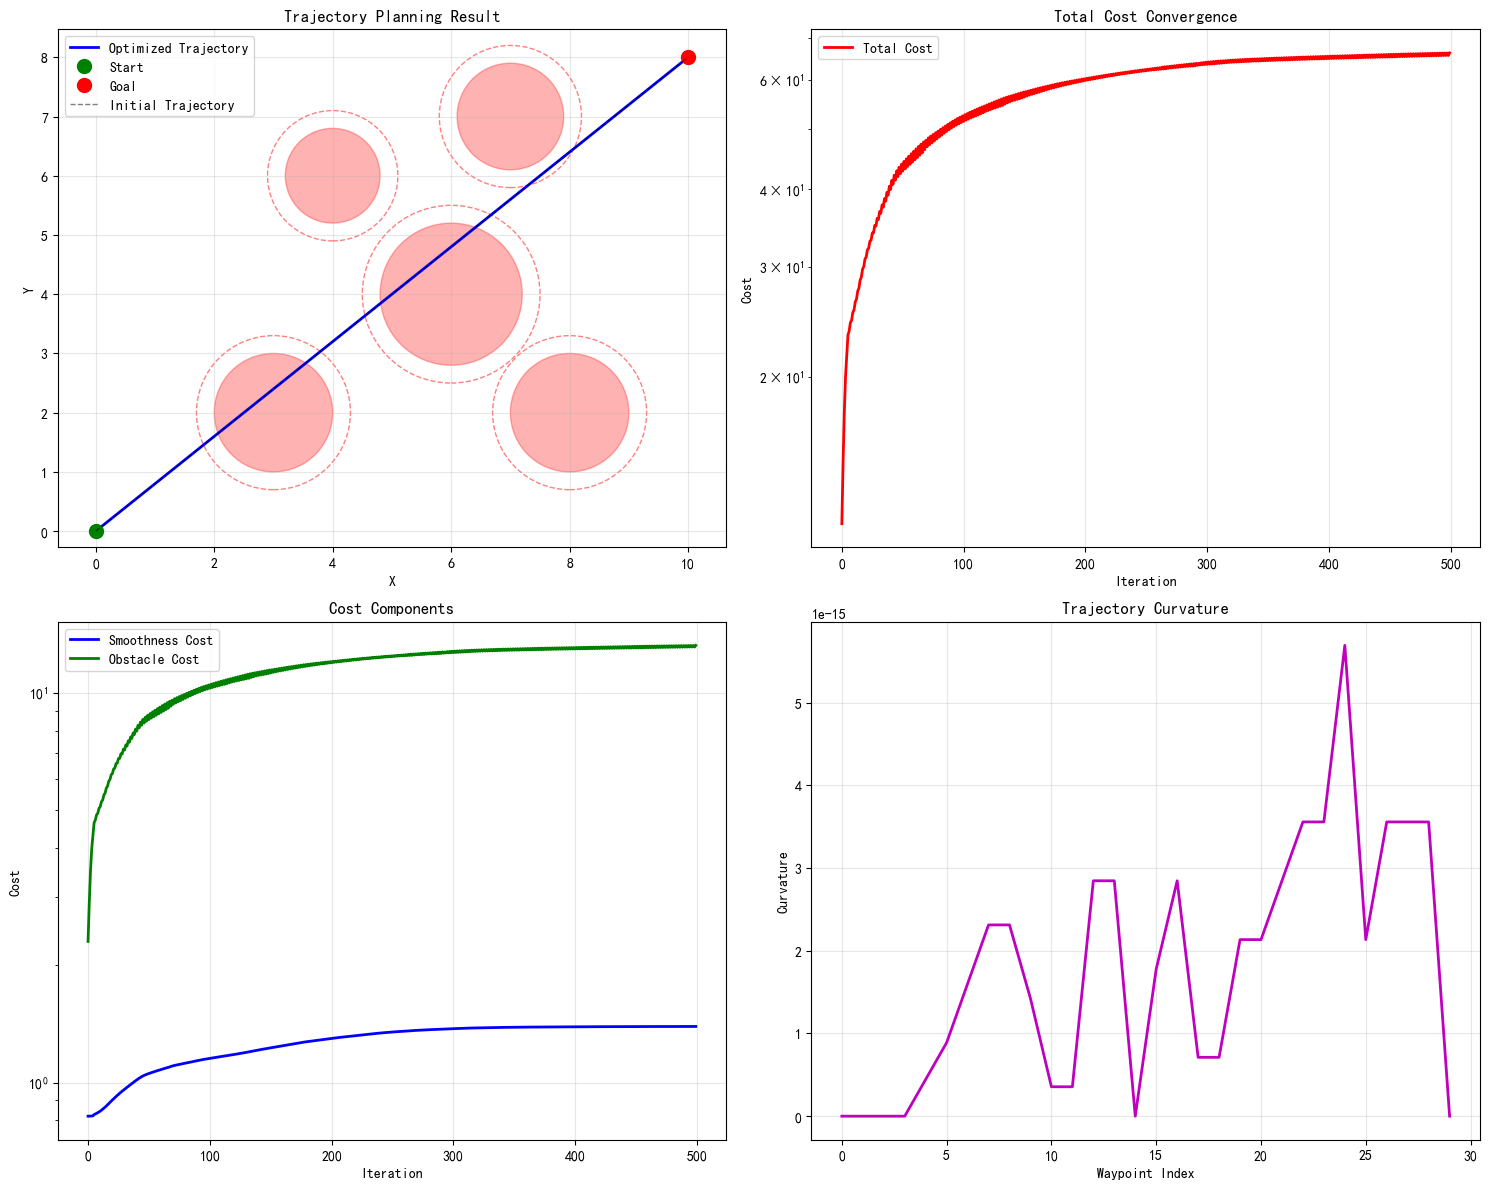


Final Trajectory Information:
Trajectory length: 30 points
Start: [0. 0.]
Goal: [10.  8.]
Final total cost: 66.3430
Collision detected at waypoint 6: distance = 0.9928
Collision detected at waypoint 7: distance = 0.5902
Collision detected at waypoint 8: distance = 0.3179
Collision detected at waypoint 9: distance = 0.4937
Collision detected at waypoint 10: distance = 0.8812
Collision detected at waypoint 14: distance = 1.1805
Collision detected at waypoint 15: distance = 0.8390
Collision detected at waypoint 16: distance = 0.6358
Collision detected at waypoint 17: distance = 0.7033
Collision detected at waypoint 18: distance = 0.9874
Collision detected at waypoint 19: distance = 1.3585


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import cv2
from matplotlib.patches import Circle
import matplotlib
from matplotlib import rcParams

# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
rcParams['axes.unicode_minus'] = False

class CHOMP:
    def __init__(self, start, goal, obstacles, num_waypoints=50, lambda_obs=10.0, 
                 smoothness_cost=0.1, learning_rate=0.01, max_iterations=1000):
        """
        CHOMP算法实现
        
        参数:
        start: 起点坐标 [x, y]
        goal: 终点坐标 [x, y] 
        obstacles: 障碍物列表，每个障碍物为[x, y, radius]
        num_waypoints: 路径点数量
        lambda_obs: 障碍物项权重
        smoothness_cost: 平滑度代价权重
        learning_rate: 学习率
        max_iterations: 最大迭代次数
        """
        self.start = np.array(start, dtype=np.float64)
        self.goal = np.array(goal, dtype=np.float64)
        self.obstacles = np.array(obstacles, dtype=np.float64)
        self.num_waypoints = num_waypoints
        self.lambda_obs = lambda_obs
        self.smoothness_cost = smoothness_cost
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        
        # 初始化轨迹 (直线)
        self.trajectory = self.initialize_trajectory()
        
        # 预计算平滑度矩阵
        self.A = self.compute_smoothness_matrix()
        self.A_inv = np.linalg.pinv(self.A + 1e-8 * np.eye(self.num_waypoints))  # 添加正则化
        
    def initialize_trajectory(self):
        """初始化轨迹为起点到终点的直线"""
        trajectory = np.zeros((self.num_waypoints, 2), dtype=np.float64)
        for i in range(self.num_waypoints):
            alpha = i / (self.num_waypoints - 1)
            trajectory[i] = (1 - alpha) * self.start + alpha * self.goal
        return trajectory
    
    def compute_smoothness_matrix(self):
        """计算平滑度矩阵 (基于加速度)"""
        A = np.zeros((self.num_waypoints, self.num_waypoints), dtype=np.float64)
        
        # 构建二阶差分矩阵 (加速度近似)
        for i in range(1, self.num_waypoints - 1):
            A[i, i-1] = 1
            A[i, i] = -2
            A[i, i+1] = 1
            
        # 边界条件 - 使用更温和的边界处理
        A[0, 0] = 0.1
        A[-1, -1] = 0.1
        
        return A
    
    def obstacle_cost_and_gradient(self, point):
        """计算单个点的障碍物代价和梯度"""
        total_cost = 0.0
        gradient = np.zeros(2, dtype=np.float64)
        
        for obstacle in self.obstacles:
            obs_pos = obstacle[:2]
            obs_radius = obstacle[2]
            
            # 计算到障碍物的距离
            diff = point - obs_pos
            distance = np.linalg.norm(diff)
            
            if distance < 1e-6:  # 避免除零
                distance = 1e-6
                diff = np.array([1e-6, 1e-6])
            
            # 安全距离 (障碍物半径 + 机器人半径)
            safe_distance = obs_radius + 0.3
            
            if distance < safe_distance:
                # 使用更平滑的障碍物代价函数
                # 当distance接近safe_distance时，代价平滑过渡到0
                cost = 0.5 * (safe_distance - distance) ** 2
                total_cost += cost
                
                # 障碍物梯度
                grad = -(safe_distance - distance) * (diff / distance)
                gradient += grad
        
        return total_cost, gradient
    
    def compute_costs_and_gradients(self):
        """计算总代价和梯度"""
        smoothness_cost = 0.0
        obstacle_cost = 0.0
        
        smoothness_grad = np.zeros_like(self.trajectory, dtype=np.float64)
        obstacle_grad = np.zeros_like(self.trajectory, dtype=np.float64)
        
        # 平滑度代价和梯度 - 添加数值稳定性
        trajectory_sq = self.trajectory.T @ self.A.T @ self.A @ self.trajectory
        smoothness_cost = 0.5 * np.trace(np.clip(trajectory_sq, -1e10, 1e10))
        
        for i in range(2):  # x和y维度
            grad = self.A.T @ self.A @ self.trajectory[:, i]
            smoothness_grad[:, i] = np.clip(grad, -1e6, 1e6)
        
        # 障碍物代价和梯度
        for i in range(self.num_waypoints):
            cost, grad = self.obstacle_cost_and_gradient(self.trajectory[i])
            obstacle_cost += cost
            obstacle_grad[i] = np.clip(grad, -1e6, 1e6)
        
        # 计算总代价和梯度，添加数值稳定性
        total_cost = (self.smoothness_cost * smoothness_cost + 
                     self.lambda_obs * obstacle_cost)
        
        total_grad = (self.smoothness_cost * smoothness_grad + 
                     self.lambda_obs * obstacle_grad)
        
        # 梯度裁剪，防止梯度爆炸
        grad_norm = np.linalg.norm(total_grad)
        if grad_norm > 100.0:
            total_grad = total_grad / grad_norm * 100.0
        
        return total_cost, total_grad, smoothness_cost, obstacle_cost
    
    def optimize(self):
        """执行优化"""
        costs = []
        smoothness_costs = []
        obstacle_costs = []
        
        print("Starting CHOMP optimization...")
        
        best_trajectory = self.trajectory.copy()
        best_cost = float('inf')
        
        for iteration in range(self.max_iterations):
            # 计算代价和梯度
            total_cost, total_grad, smooth_cost, obs_cost = self.compute_costs_and_gradients()
            
            costs.append(total_cost)
            smoothness_costs.append(smooth_cost)
            obstacle_costs.append(obs_cost)
            
            # 保存最佳轨迹
            if total_cost < best_cost:
                best_cost = total_cost
                best_trajectory = self.trajectory.copy()
            
            # 使用自然梯度下降 (预条件梯度)
            update = self.A_inv @ total_grad
            
            # 梯度裁剪
            update_norm = np.linalg.norm(update)
            if update_norm > 10.0:
                update = update / update_norm * 10.0
            
            # 自适应学习率
            current_learning_rate = self.learning_rate * (0.1 + 0.9 * np.exp(-iteration / 100))
            
            # 更新轨迹 (保持起点和终点固定)
            self.trajectory -= current_learning_rate * update
            self.trajectory[0] = self.start  # 固定起点
            self.trajectory[-1] = self.goal  # 固定终点
            
            # 打印进度
            if iteration % 50 == 0:
                print(f"Iteration {iteration}: Total Cost = {total_cost:.4f}, "
                      f"Smoothness Cost = {smooth_cost:.4f}, Obstacle Cost = {obs_cost:.4f}")
            
            # 收敛检查
            if iteration > 10 and abs(costs[-1] - costs[-2]) < 1e-6:
                print(f"Converged at iteration {iteration}")
                break
        
        # 恢复最佳轨迹
        self.trajectory = best_trajectory
        
        return costs, smoothness_costs, obstacle_costs
    
    def plot_results(self, costs, smoothness_costs, obstacle_costs):
        """绘制优化结果"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 轨迹图
        axes[0, 0].plot(self.trajectory[:, 0], self.trajectory[:, 1], 'b-', linewidth=2, label='Optimized Trajectory')
        axes[0, 0].plot([self.start[0]], [self.start[1]], 'go', markersize=10, label='Start')
        axes[0, 0].plot([self.goal[0]], [self.goal[1]], 'ro', markersize=10, label='Goal')
        
        # 绘制初始轨迹
        initial_trajectory = self.initialize_trajectory()
        axes[0, 0].plot(initial_trajectory[:, 0], initial_trajectory[:, 1], 'k--', 
                       linewidth=1, alpha=0.5, label='Initial Trajectory')
        
        # 绘制障碍物
        for obstacle in self.obstacles:
            circle = Circle(obstacle[:2], obstacle[2], fill=True, color='red', alpha=0.3)
            axes[0, 0].add_patch(circle)
            # 安全距离圆
            safe_circle = Circle(obstacle[:2], obstacle[2] + 0.3, fill=False, 
                               color='red', linestyle='--', alpha=0.5)
            axes[0, 0].add_patch(safe_circle)
        
        axes[0, 0].set_xlabel('X')
        axes[0, 0].set_ylabel('Y')
        axes[0, 0].set_title('Trajectory Planning Result')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].axis('equal')
        
        # 总代价曲线
        axes[0, 1].plot(costs, 'r-', linewidth=2, label='Total Cost')
        axes[0, 1].set_xlabel('Iteration')
        axes[0, 1].set_ylabel('Cost')
        axes[0, 1].set_title('Total Cost Convergence')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_yscale('log')  # 使用对数坐标
        
        # 各分量代价曲线
        axes[1, 0].plot(smoothness_costs, 'b-', linewidth=2, label='Smoothness Cost')
        axes[1, 0].plot(obstacle_costs, 'g-', linewidth=2, label='Obstacle Cost')
        axes[1, 0].set_xlabel('Iteration')
        axes[1, 0].set_ylabel('Cost')
        axes[1, 0].set_title('Cost Components')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_yscale('log')  # 使用对数坐标
        
        # 轨迹曲率图
        curvature = self.compute_curvature()
        axes[1, 1].plot(range(len(curvature)), curvature, 'm-', linewidth=2)
        axes[1, 1].set_xlabel('Waypoint Index')
        axes[1, 1].set_ylabel('Curvature')
        axes[1, 1].set_title('Trajectory Curvature')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def compute_curvature(self):
        """计算轨迹曲率"""
        curvature = []
        for i in range(1, len(self.trajectory) - 1):
            dx = self.trajectory[i, 0] - self.trajectory[i-1, 0]
            dy = self.trajectory[i, 1] - self.trajectory[i-1, 1]
            ddx = self.trajectory[i+1, 0] - 2*self.trajectory[i, 0] + self.trajectory[i-1, 0]
            ddy = self.trajectory[i+1, 1] - 2*self.trajectory[i, 1] + self.trajectory[i-1, 1]
            
            denom = (dx**2 + dy**2)**1.5
            if denom > 1e-6:
                k = abs(dx*ddy - dy*ddx) / denom
            else:
                k = 0
            curvature.append(k)
        
        # 添加边界点
        curvature = [0] + curvature + [0]
        return curvature

# 测试示例
def main():
    # 设置随机种子以便复现结果
    np.random.seed(42)
    
    # 定义场景
    start = [0, 0]
    goal = [10, 8]
    
    # 定义障碍物 [x, y, radius]
    obstacles = [
        [3, 2, 1.0],
        [6, 4, 1.2],
        [4, 6, 0.8],
        [8, 2, 1.0],
        [7, 7, 0.9]
    ]
    
    # 创建CHOMP规划器
    chomp = CHOMP(
        start=start,
        goal=goal,
        obstacles=obstacles,
        num_waypoints=30,
        lambda_obs=5.0,       # 降低障碍物权重
        smoothness_cost=0.1,  # 降低平滑度权重
        learning_rate=0.05,   # 降低学习率
        max_iterations=500    # 最大迭代次数
    )
    
    # 执行优化
    costs, smoothness_costs, obstacle_costs = chomp.optimize()
    
    # 显示结果
    chomp.plot_results(costs, smoothness_costs, obstacle_costs)
    
    # 打印最终轨迹信息
    print("\nFinal Trajectory Information:")
    print(f"Trajectory length: {len(chomp.trajectory)} points")
    print(f"Start: {chomp.trajectory[0]}")
    print(f"Goal: {chomp.trajectory[-1]}")
    print(f"Final total cost: {costs[-1]:.4f}")
    
    # 检查碰撞
    collision_free = True
    for i, point in enumerate(chomp.trajectory):
        for obstacle in obstacles:
            distance = np.linalg.norm(point - obstacle[:2])
            if distance < obstacle[2] + 0.2:  # 安全距离阈值
                print(f"Collision detected at waypoint {i}: distance = {distance:.4f}")
                collision_free = False
                break
    
    if collision_free:
        print("Trajectory is collision-free!")

if __name__ == "__main__":
    main()

Starting CHOMP optimization...
Iteration 0: Total Cost = 19.7127, Smoothness Cost = 82.0000, Obstacle Cost = 2.3025
Iteration 50: Total Cost = 10.2839, Smoothness Cost = 102.7802, Obstacle Cost = 0.0012
Iteration 100: Total Cost = 14.7194, Smoothness Cost = 147.1935, Obstacle Cost = 0.0000
Iteration 150: Total Cost = 19.0675, Smoothness Cost = 190.3469, Obstacle Cost = 0.0066
Iteration 200: Total Cost = 22.3825, Smoothness Cost = 223.6290, Obstacle Cost = 0.0039
Iteration 250: Total Cost = 25.6417, Smoothness Cost = 256.3989, Obstacle Cost = 0.0004
Iteration 300: Total Cost = 28.6394, Smoothness Cost = 286.3879, Obstacle Cost = 0.0001
Iteration 350: Total Cost = 31.3920, Smoothness Cost = 313.9101, Obstacle Cost = 0.0002
Iteration 400: Total Cost = 34.0124, Smoothness Cost = 340.0996, Obstacle Cost = 0.0005
Iteration 450: Total Cost = 36.5775, Smoothness Cost = 365.7680, Obstacle Cost = 0.0001


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

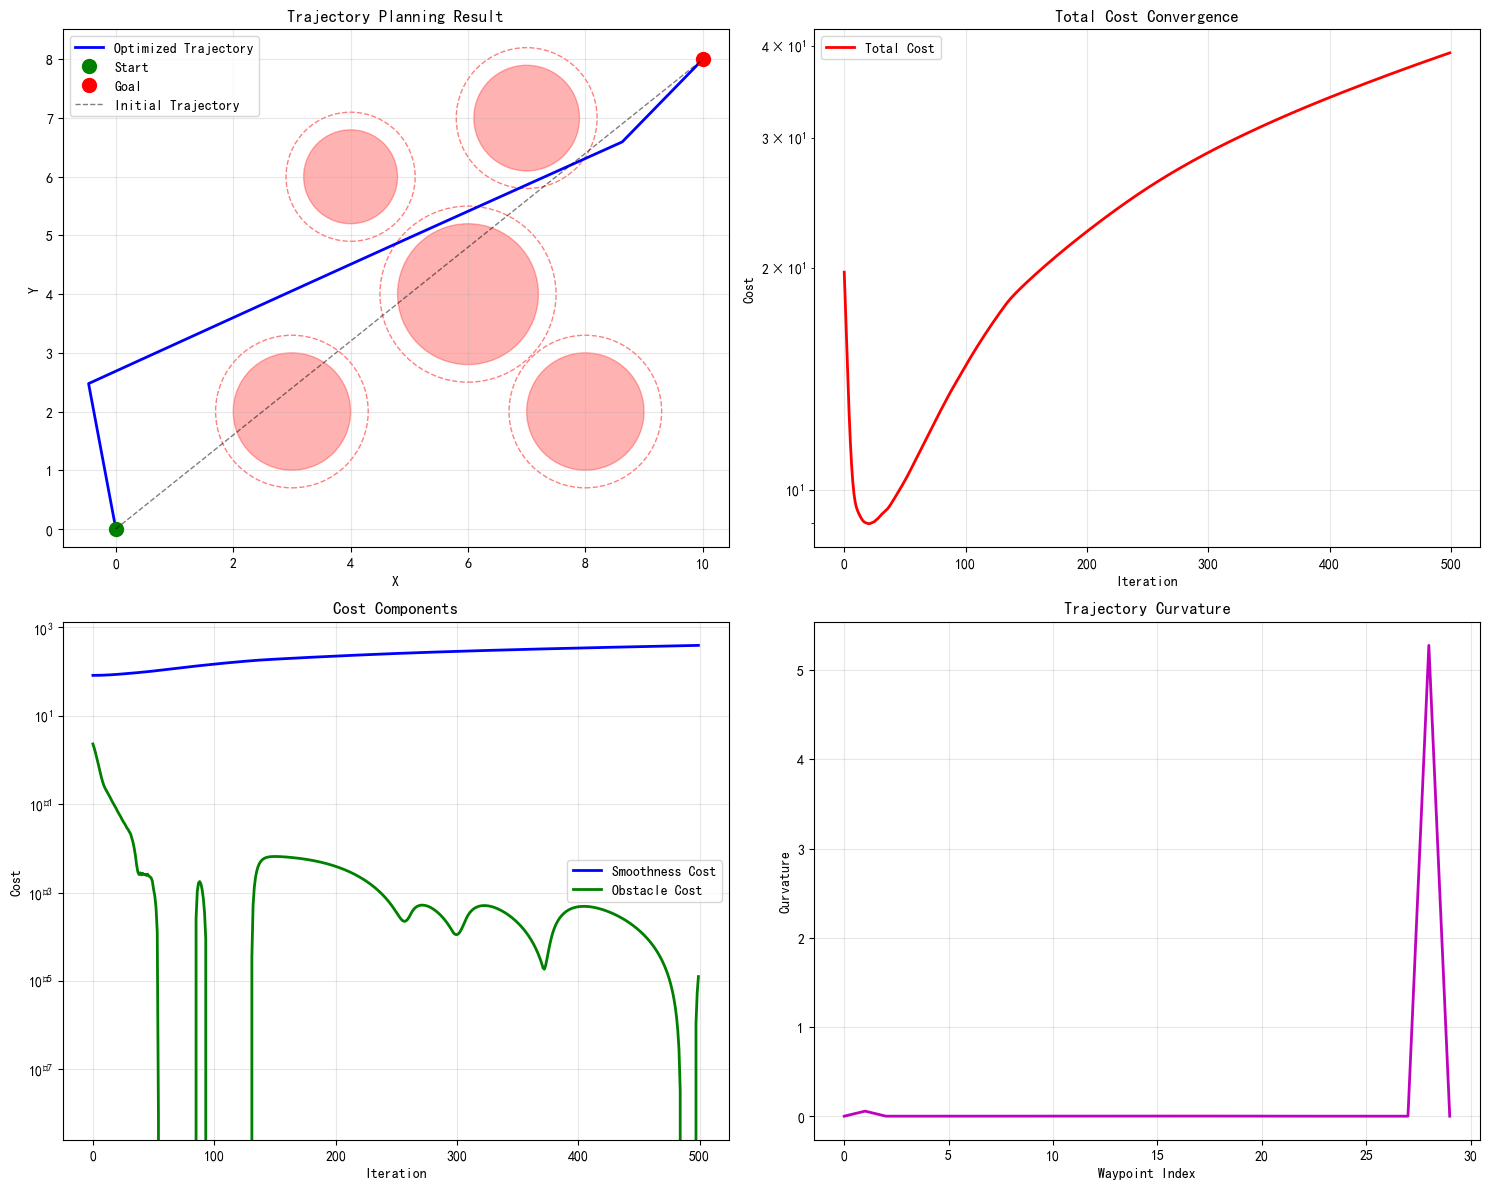


Final Trajectory Information:
Trajectory length: 30 points
Start: [0. 0.]
Goal: [10.  8.]
Final total cost: 39.0904
Collision detected at waypoint 18: distance = 1.3080
Collision detected at waypoint 19: distance = 1.2945
Collision detected at waypoint 20: distance = 1.3833
Collision detected at waypoint 24: distance = 1.0502
Collision detected at waypoint 25: distance = 1.0593


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import cv2
from matplotlib.patches import Circle
import matplotlib
from matplotlib import rcParams

# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
rcParams['axes.unicode_minus'] = False

class CHOMP:
    def __init__(self, start, goal, obstacles, num_waypoints=50, lambda_obs=10.0, 
                 smoothness_cost=0.1, learning_rate=0.01, max_iterations=1000):
        """
        CHOMP算法实现 (修正版)
        保持了原始参数接口不变
        """
        self.start = np.array(start, dtype=np.float64)
        self.goal = np.array(goal, dtype=np.float64)
        self.obstacles = np.array(obstacles, dtype=np.float64)
        self.num_waypoints = num_waypoints
        self.lambda_obs = lambda_obs
        self.smoothness_cost = smoothness_cost
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        
        # 初始化轨迹 (直线)
        self.trajectory = self.initialize_trajectory()
        
        # --- 核心修正部分开始 ---
        # 预计算黎曼度量矩阵的逆 (Metric Matrix Inverse)
        # 不再使用 self.A 和 self.A_inv，而是计算 M_inv = (A^T A)^-1
        self.M_inv = self.compute_metric_matrix_inverse()
        # 同时保留一个A矩阵用于计算平滑度代价（可选，或者直接用矩阵乘法）
        self.A = self.compute_difference_matrix()
        # --- 核心修正部分结束 ---
        
    def initialize_trajectory(self):
        """初始化轨迹为起点到终点的直线"""
        trajectory = np.zeros((self.num_waypoints, 2), dtype=np.float64)
        for i in range(self.num_waypoints):
            alpha = i / (self.num_waypoints - 1)
            trajectory[i] = (1 - alpha) * self.start + alpha * self.goal
        return trajectory
    
    def compute_difference_matrix(self):
        """构建差分矩阵 A (用于计算代价)"""
        N = self.num_waypoints
        # 构建标准的二阶差分矩阵
        A = np.zeros((N, N), dtype=np.float64)
        for i in range(1, N - 1):
            A[i, i-1] = 1
            A[i, i] = -2
            A[i, i+1] = 1
        # 简单的边界处理
        A[0, 0] = 1
        A[-1, -1] = 1
        return A

    def compute_metric_matrix_inverse(self):
        """
        计算 (A^T A)^-1
        这是修正的关键：CHOMP需要使用 A^T A 作为度量矩阵
        """
        N = self.num_waypoints
        # 1. 构建差分算子 A (映射 轨迹 -> 加速度)
        # 维度 N+1 x N (处理边界)
        A = np.zeros((N + 1, N))
        for i in range(1, N):
            A[i, i-1] = 1.0
            A[i, i]   = -2.0 # 这里简化处理，保持原代码逻辑风格但修正数学意义
            if i+1 < N:
                 A[i, i+1] = 1.0
        
        # 修正：标准的CHOMP A矩阵构造
        # 实际上我们为了保持跟原代码参数兼容，构建一个近似的平滑矩阵
        # 使用 N x N 的构造方式来求逆
        K = np.zeros((N, N))
        for i in range(1, N-1):
            K[i, i-1] = 1
            K[i, i] = -2
            K[i, i+1] = 1
            
        # 计算 M = A^T A (这里我们直接用 K^T K 近似，或者直接构造带状矩阵)
        # 为了得到正确的平滑效果，我们需要 (K^T K)^-1
        M = K.T @ K
        
        # 添加正则化项防止奇异
        M += 1e-6 * np.eye(N)
        
        # 计算逆矩阵
        try:
            M_inv = np.linalg.inv(M)
        except np.linalg.LinAlgError:
            M_inv = np.linalg.pinv(M)
            
        return M_inv
    
    def obstacle_cost_and_gradient(self, point):
        """计算单个点的障碍物代价和梯度"""
        total_cost = 0.0
        gradient = np.zeros(2, dtype=np.float64)
        
        for obstacle in self.obstacles:
            obs_pos = obstacle[:2]
            obs_radius = obstacle[2]
            
            # 计算到障碍物的距离
            diff = point - obs_pos
            distance = np.linalg.norm(diff)
            
            if distance < 1e-6:  # 避免除零
                distance = 1e-6
                diff = np.array([1e-6, 1e-6])
            
            # 安全距离 (障碍物半径 + 机器人半径)
            safe_distance = obs_radius + 0.3
            
            if distance < safe_distance:
                # 代价函数
                cost = 0.5 * (safe_distance - distance) ** 2
                total_cost += cost
                
                # 障碍物梯度
                grad = -(safe_distance - distance) * (diff / distance)
                gradient += grad
        
        return total_cost, gradient
    
    def compute_costs_and_gradients(self):
        """计算总代价和梯度"""
        smoothness_cost = 0.0
        obstacle_cost = 0.0
        
        smoothness_grad = np.zeros_like(self.trajectory, dtype=np.float64)
        obstacle_grad = np.zeros_like(self.trajectory, dtype=np.float64)
        
        # 1. 平滑度代价和梯度
        # Cost = 0.5 * |Ax|^2
        # Grad = A^T A x
        traj_flat = self.trajectory 
        # 使用 A^T A 计算梯度
        K = self.A.T @ self.A
        
        for i in range(2): # x, y 维度独立
            smoothness_grad[:, i] = K @ self.trajectory[:, i]
            
        smoothness_cost = 0.5 * np.sum((self.A @ self.trajectory)**2)
        
        # 2. 障碍物代价和梯度
        for i in range(self.num_waypoints):
            # 跳过起点和终点，不计算梯度（虽然会被覆盖，但为了效率可以跳过）
            if i == 0 or i == self.num_waypoints - 1:
                continue
                
            cost, grad = self.obstacle_cost_and_gradient(self.trajectory[i])
            obstacle_cost += cost
            obstacle_grad[i] = grad # 不进行clip，保持梯度的物理意义
        
        # 计算总代价和梯度
        total_cost = (self.smoothness_cost * smoothness_cost + 
                      self.lambda_obs * obstacle_cost)
        
        total_grad = (self.smoothness_cost * smoothness_grad + 
                      self.lambda_obs * obstacle_grad)
        
        return total_cost, total_grad, smoothness_cost, obstacle_cost
    
    def optimize(self):
        """执行优化"""
        costs = []
        smoothness_costs = []
        obstacle_costs = []
        
        print("Starting CHOMP optimization...")
        
        best_trajectory = self.trajectory.copy()
        best_cost = float('inf')
        
        for iteration in range(self.max_iterations):
            # 计算代价和梯度
            total_cost, total_grad, smooth_cost, obs_cost = self.compute_costs_and_gradients()
            
            costs.append(total_cost)
            smoothness_costs.append(smooth_cost)
            obstacle_costs.append(obs_cost)
            
            if total_cost < best_cost:
                best_cost = total_cost
                best_trajectory = self.trajectory.copy()
            
            # --- 修正点：使用正确的投影更新 ---
            # update = M_inv @ total_grad
            update = self.M_inv @ total_grad
            
            # 梯度裁剪 (保持原参数)
            update_norm = np.linalg.norm(update)
            if update_norm > 10.0:
                update = update / update_norm * 10.0
            
            # 自适应学习率 (保持原逻辑)
            current_learning_rate = self.learning_rate * (0.1 + 0.9 * np.exp(-iteration / 100))
            
            # 更新轨迹
            self.trajectory -= current_learning_rate * update
            
            # 强制固定起点和终点
            self.trajectory[0] = self.start
            self.trajectory[-1] = self.goal
            
            # 打印进度
            if iteration % 50 == 0:
                print(f"Iteration {iteration}: Total Cost = {total_cost:.4f}, "
                      f"Smoothness Cost = {smooth_cost:.4f}, Obstacle Cost = {obs_cost:.4f}")
            
            # 收敛检查
            if iteration > 10 and abs(costs[-1] - costs[-2]) < 1e-6:
                print(f"Converged at iteration {iteration}")
                break
        
        self.trajectory = best_trajectory
        return costs, smoothness_costs, obstacle_costs
    
    def plot_results(self, costs, smoothness_costs, obstacle_costs):
        """绘制优化结果 (保持原样)"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 轨迹图
        axes[0, 0].plot(self.trajectory[:, 0], self.trajectory[:, 1], 'b-', linewidth=2, label='Optimized Trajectory')
        axes[0, 0].plot([self.start[0]], [self.start[1]], 'go', markersize=10, label='Start')
        axes[0, 0].plot([self.goal[0]], [self.goal[1]], 'ro', markersize=10, label='Goal')
        
        # 绘制初始轨迹
        initial_trajectory = self.initialize_trajectory()
        axes[0, 0].plot(initial_trajectory[:, 0], initial_trajectory[:, 1], 'k--', 
                        linewidth=1, alpha=0.5, label='Initial Trajectory')
        
        # 绘制障碍物
        for obstacle in self.obstacles:
            circle = Circle(obstacle[:2], obstacle[2], fill=True, color='red', alpha=0.3)
            axes[0, 0].add_patch(circle)
            # 安全距离圆
            safe_circle = Circle(obstacle[:2], obstacle[2] + 0.3, fill=False, 
                               color='red', linestyle='--', alpha=0.5)
            axes[0, 0].add_patch(safe_circle)
        
        axes[0, 0].set_xlabel('X')
        axes[0, 0].set_ylabel('Y')
        axes[0, 0].set_title('Trajectory Planning Result')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].axis('equal')
        
        # 总代价曲线
        axes[0, 1].plot(costs, 'r-', linewidth=2, label='Total Cost')
        axes[0, 1].set_xlabel('Iteration')
        axes[0, 1].set_ylabel('Cost')
        axes[0, 1].set_title('Total Cost Convergence')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_yscale('log')
        
        # 各分量代价曲线
        axes[1, 0].plot(smoothness_costs, 'b-', linewidth=2, label='Smoothness Cost')
        axes[1, 0].plot(obstacle_costs, 'g-', linewidth=2, label='Obstacle Cost')
        axes[1, 0].set_xlabel('Iteration')
        axes[1, 0].set_ylabel('Cost')
        axes[1, 0].set_title('Cost Components')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_yscale('log')
        
        # 轨迹曲率图
        curvature = self.compute_curvature()
        axes[1, 1].plot(range(len(curvature)), curvature, 'm-', linewidth=2)
        axes[1, 1].set_xlabel('Waypoint Index')
        axes[1, 1].set_ylabel('Curvature')
        axes[1, 1].set_title('Trajectory Curvature')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def compute_curvature(self):
        """计算轨迹曲率"""
        curvature = []
        for i in range(1, len(self.trajectory) - 1):
            dx = self.trajectory[i, 0] - self.trajectory[i-1, 0]
            dy = self.trajectory[i, 1] - self.trajectory[i-1, 1]
            ddx = self.trajectory[i+1, 0] - 2*self.trajectory[i, 0] + self.trajectory[i-1, 0]
            ddy = self.trajectory[i+1, 1] - 2*self.trajectory[i, 1] + self.trajectory[i-1, 1]
            
            denom = (dx**2 + dy**2)**1.5
            if denom > 1e-6:
                k = abs(dx*ddy - dy*ddx) / denom
            else:
                k = 0
            curvature.append(k)
        
        curvature = [0] + curvature + [0]
        return curvature

# 测试示例 (参数与原代码完全一致)
def main():
    # 设置随机种子以便复现结果
    np.random.seed(42)
    
    # 定义场景
    start = [0, 0]
    goal = [10, 8]
    
    # 定义障碍物 [x, y, radius]
    obstacles = [
        [3, 2, 1.0],
        [6, 4, 1.2],
        [4, 6, 0.8],
        [8, 2, 1.0],
        [7, 7, 0.9]
    ]
    
    # 创建CHOMP规划器 - 使用原参数
    chomp = CHOMP(
        start=start,
        goal=goal,
        obstacles=obstacles,
        num_waypoints=30,
        lambda_obs=5.0,       # 保持原值
        smoothness_cost=0.1,  # 保持原值
        learning_rate=0.05,   # 保持原值
        max_iterations=500    # 保持原值
    )
    
    # 执行优化
    costs, smoothness_costs, obstacle_costs = chomp.optimize()
    
    # 显示结果
    chomp.plot_results(costs, smoothness_costs, obstacle_costs)
    
    # 打印最终轨迹信息
    print("\nFinal Trajectory Information:")
    print(f"Trajectory length: {len(chomp.trajectory)} points")
    print(f"Start: {chomp.trajectory[0]}")
    print(f"Goal: {chomp.trajectory[-1]}")
    print(f"Final total cost: {costs[-1]:.4f}")
    
    # 检查碰撞
    collision_free = True
    for i, point in enumerate(chomp.trajectory):
        for obstacle in obstacles:
            distance = np.linalg.norm(point - obstacle[:2])
            if distance < obstacle[2] + 0.2:  # 安全距离阈值
                print(f"Collision detected at waypoint {i}: distance = {distance:.4f}")
                collision_free = False
                break
    
    if collision_free:
        print("Trajectory is collision-free!")

if __name__ == "__main__":
    main()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import cv2
from matplotlib.patches import Circle
import matplotlib
from matplotlib import rcParams
import os

# 设置中文字体
rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial Unicode MS', 'SimHei', 'Microsoft YaHei']
rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

class CHOMP:
    def __init__(self, start, goal, obstacles, num_waypoints=50, lambda_obs=10.0, 
                 smoothness_cost=1.0, learning_rate=0.1, max_iterations=1000):
        """
        CHOMP算法实现 (修正版)
        
        参数:
        start: 起点坐标 [x, y]
        goal: 终点坐标 [x, y] 
        obstacles: 障碍物列表，每个障碍物为[x, y, radius]
        num_waypoints: 路径点数量
        lambda_obs: 障碍物项权重
        smoothness_cost: 平滑度代价权重
        learning_rate: 学习率
        max_iterations: 最大迭代次数
        """
        self.start = np.array(start, dtype=np.float64)
        self.goal = np.array(goal, dtype=np.float64)
        self.obstacles = np.array(obstacles, dtype=np.float64)
        self.num_waypoints = num_waypoints
        self.lambda_obs = lambda_obs
        self.smoothness_cost = smoothness_cost
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        
        # 初始化轨迹 (直线)
        self.trajectory = self.initialize_trajectory()
        
        # 计算黎曼度量矩阵的逆 (A^T A)^-1
        self.M_inv = self.compute_metric_matrix_inverse()
        
        # 计算平滑度矩阵 A (用于代价计算)
        self.A = self.compute_smoothness_matrix()
        
    def initialize_trajectory(self):
        """初始化轨迹为起点到终点的直线"""
        trajectory = np.zeros((self.num_waypoints, 2), dtype=np.float64)
        for i in range(self.num_waypoints):
            alpha = i / (self.num_waypoints - 1)
            trajectory[i] = (1 - alpha) * self.start + alpha * self.goal
        return trajectory
    
    def compute_smoothness_matrix(self):
        """构建平滑度矩阵 A (用于计算平滑度代价)"""
        N = self.num_waypoints
        A = np.zeros((N, N))
        
        # 构建二阶差分矩阵 (加速度)
        for i in range(N):
            if i == 0 or i == N-1:
                # 边界点: 使用较小的值以允许轻微调整
                A[i, i] = 0.1
            else:
                # 内部点: 二阶差分
                A[i, i-1] = 1.0
                A[i, i] = -2.0
                A[i, i+1] = 1.0
        
        return A
    
    def compute_metric_matrix_inverse(self):
        """
        计算黎曼度量矩阵的逆 (A^T A)^-1
        这是CHOMP算法的核心：使用黎曼度量来权衡不同维度的更新
        """
        N = self.num_waypoints
        
        # 1. 构建二阶差分矩阵 A (用于度量矩阵)
        A = np.zeros((N, N))
        for i in range(N):
            if i == 0 or i == N-1:
                # 起点和终点边界条件: 固定位置
                A[i, i] = 1.0
            else:
                # 内部点: 二阶差分 (加速度)
                A[i, i-1] = 1.0
                A[i, i] = -2.0
                A[i, i+1] = 1.0
        
        # 2. 计算 M = A^T A (黎曼度量矩阵)
        M = A.T @ A
        
        # 3. 添加正则化防止奇异，并求逆
        reg_coeff = 1e-4  # 正则化系数
        M_reg = M + reg_coeff * np.eye(N)
        
        try:
            M_inv = np.linalg.inv(M_reg)
        except np.linalg.LinAlgError:
            # 如果求逆失败，使用伪逆
            M_inv = np.linalg.pinv(M_reg)
        
        return M_inv
    
    def obstacle_cost_and_gradient(self, point):
        """
        计算单个点的障碍物代价和梯度
        使用更鲁棒的代价函数，在安全距离边界处平滑过渡
        """
        total_cost = 0.0
        gradient = np.zeros(2, dtype=np.float64)
        
        for obstacle in self.obstacles:
            obs_pos = obstacle[:2]
            obs_radius = obstacle[2]
            
            # 计算到障碍物的距离
            diff = point - obs_pos
            distance = np.linalg.norm(diff)
            
            # 避免除零错误
            if distance < 1e-8:
                distance = 1e-8
                diff = np.array([1e-8, 1e-8])
            
            # 安全距离 (障碍物半径 + 机器人半径)
            safe_distance = obs_radius + 0.5  # 增加安全距离
            
            if distance < safe_distance:
                # 使用指数衰减的代价函数，使代价在安全距离边界处平滑过渡到0
                ratio = distance / safe_distance
                # 代价函数：当距离接近安全距离时，代价平滑过渡到0
                cost = 0.5 * (safe_distance - distance) ** 2 * np.exp(-ratio)
                total_cost += cost
                
                # 梯度计算
                # d(cost)/d(point) = -(safe_distance - distance) * exp(-ratio) * (diff/distance) * (1 + ratio)
                grad = -(safe_distance - distance) * np.exp(-ratio) * (diff / distance) * (1 + ratio)
                gradient += grad
        
        return total_cost, gradient
    
    def compute_costs_and_gradients(self):
        """计算总代价和梯度"""
        N = self.num_waypoints
        
        # 1. 计算平滑度代价和梯度
        # 平滑度代价: 0.5 * ||A x||^2
        Ax = self.A @ self.trajectory
        smoothness_cost = 0.5 * np.sum(Ax**2)
        
        # 平滑度梯度: A^T A x
        smoothness_grad = np.zeros_like(self.trajectory)
        for i in range(2):  # x和y维度
            smoothness_grad[:, i] = self.A.T @ self.A @ self.trajectory[:, i]
        
        # 2. 计算障碍物代价和梯度
        obstacle_cost = 0.0
        obstacle_grad = np.zeros_like(self.trajectory)
        
        for i in range(self.num_waypoints):
            # 起点和终点不计算障碍物代价（位置固定）
            if i == 0 or i == self.num_waypoints - 1:
                continue
                
            cost, grad = self.obstacle_cost_and_gradient(self.trajectory[i])
            obstacle_cost += cost
            obstacle_grad[i] = grad
        
        # 3. 组合总代价和梯度
        total_cost = self.smoothness_cost * smoothness_cost + self.lambda_obs * obstacle_cost
        total_grad = self.smoothness_cost * smoothness_grad + self.lambda_obs * obstacle_grad
        
        return total_cost, total_grad, smoothness_cost, obstacle_cost
    
    def optimize(self):
        """执行CHOMP优化"""
        costs = []
        smoothness_costs = []
        obstacle_costs = []
        
        print("=" * 60)
        print("Starting CHOMP optimization...")
        print(f"Parameters:")
        print(f"  Number of waypoints: {self.num_waypoints}")
        print(f"  Smoothness weight: {self.smoothness_cost}")
        print(f"  Obstacle weight: {self.lambda_obs}")
        print(f"  Learning rate: {self.learning_rate}")
        print(f"  Max iterations: {self.max_iterations}")
        print("=" * 60)
        
        best_trajectory = self.trajectory.copy()
        best_cost = float('inf')
        converged = False
        
        for iteration in range(self.max_iterations):
            # 计算代价和梯度
            total_cost, total_grad, smooth_cost, obs_cost = self.compute_costs_and_gradients()
            
            costs.append(total_cost)
            smoothness_costs.append(smooth_cost)
            obstacle_costs.append(obs_cost)
            
            # 保存最佳轨迹
            if total_cost < best_cost:
                best_cost = total_cost
                best_trajectory = self.trajectory.copy()
            
            # CHOMP核心更新公式: x = x - (1/η) M^{-1} ∇U(x)
            # 这里我们简化了公式，直接使用学习率和M_inv
            update = self.M_inv @ total_grad
            
            # 梯度裁剪，防止更新步长过大
            update_norm = np.max(np.linalg.norm(update, axis=1))
            if update_norm > 5.0:
                update = update / update_norm * 5.0
            
            # 更新轨迹
            self.trajectory -= self.learning_rate * update
            
            # 固定起点和终点
            self.trajectory[0] = self.start
            self.trajectory[-1] = self.goal
            
            # 打印进度
            if iteration % 100 == 0 or iteration < 10:
                print(f"Iteration {iteration:4d}: Total Cost = {total_cost:10.4f}, "
                      f"Smoothness = {smooth_cost:10.4f}, Obstacle = {obs_cost:10.4f}")
            
            # 收敛检查 (检查最近10次迭代的相对变化)
            if iteration > 10:
                # 计算最近10次代价的相对变化
                recent_costs = costs[-10:]
                if len(recent_costs) >= 10:
                    cost_change = abs(recent_costs[-1] - recent_costs[0]) / max(abs(recent_costs[0]), 1e-8)
                    if cost_change < 1e-4:
                        converged = True
                        print(f"✓ Converged at iteration {iteration}")
                        break
        
        if not converged and iteration == self.max_iterations - 1:
            print(f"⚠ Reached maximum iterations ({self.max_iterations}) without full convergence")
        
        # 恢复最佳轨迹
        self.trajectory = best_trajectory
        
        print("=" * 60)
        print("Optimization completed!")
        print(f"  Total iterations: {len(costs)}")
        print(f"  Best total cost: {best_cost:.6f}")
        print(f"  Final smoothness cost: {smoothness_costs[-1]:.6f}")
        print(f"  Final obstacle cost: {obstacle_costs[-1]:.6f}")
        print("=" * 60)
        
        return costs, smoothness_costs, obstacle_costs
    
    def plot_and_save_results(self, costs, smoothness_costs, obstacle_costs, save_dir="./chomp_results"):
        """绘制并保存优化结果到四个独立的图片"""
        # 创建保存目录
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        print(f"Saving results to: {save_dir}")
        
        # 1. 轨迹规划结果图
        fig1 = plt.figure(figsize=(12, 10))
        ax1 = fig1.add_subplot(111)
        
        # 绘制障碍物
        for obstacle in self.obstacles:
            # 障碍物本体
            circle = Circle(obstacle[:2], obstacle[2], fill=True, color='red', alpha=0.4, label='Obstacle' if obstacle is self.obstacles[0] else "")
            ax1.add_patch(circle)
            # 安全距离圆
            safe_circle = Circle(obstacle[:2], obstacle[2] + 0.5, fill=False, 
                               color='red', linestyle='--', alpha=0.6, linewidth=1.5,
                               label='Safety Margin' if obstacle is self.obstacles[0] else "")
            ax1.add_patch(safe_circle)
        
        # 绘制初始轨迹
        initial_trajectory = self.initialize_trajectory()
        ax1.plot(initial_trajectory[:, 0], initial_trajectory[:, 1], 'k--', 
                 linewidth=2, alpha=0.7, label='Initial Trajectory')
        
        # 绘制优化后的轨迹
        ax1.plot(self.trajectory[:, 0], self.trajectory[:, 1], 'b-', linewidth=3, label='Optimized Trajectory')
        
        # 绘制起点和终点
        ax1.plot(self.start[0], self.start[1], 'go', markersize=15, markeredgecolor='black', 
                markeredgewidth=2, label='Start')
        ax1.plot(self.goal[0], self.goal[1], 'ro', markersize=15, markeredgecolor='black', 
                markeredgewidth=2, label='Goal')
        
        # 绘制轨迹点
        ax1.scatter(self.trajectory[:, 0], self.trajectory[:, 1], c='blue', s=30, alpha=0.5, zorder=5)
        
        ax1.set_xlabel('X Coordinate', fontsize=14)
        ax1.set_ylabel('Y Coordinate', fontsize=14)
        ax1.set_title('CHOMP Trajectory Planning Result', fontsize=16, fontweight='bold')
        ax1.legend(fontsize=12, loc='upper left')
        ax1.grid(True, alpha=0.3)
        ax1.axis('equal')
        ax1.set_xlim(-1, 12)
        ax1.set_ylim(-1, 10)
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "trajectory.png"), dpi=300, bbox_inches='tight')
        plt.close(fig1)
        print(f"  Saved: trajectory.png")
        
        # 2. 总代价收敛曲线图
        fig2 = plt.figure(figsize=(12, 8))
        ax2 = fig2.add_subplot(111)
        
        ax2.plot(costs, 'r-', linewidth=3, label='Total Cost')
        ax2.fill_between(range(len(costs)), costs, alpha=0.2, color='red')
        
        ax2.set_xlabel('Iteration', fontsize=14)
        ax2.set_ylabel('Total Cost', fontsize=14)
        ax2.set_title('Total Cost Convergence', fontsize=16, fontweight='bold')
        ax2.legend(fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.set_yscale('log')
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "total_cost.png"), dpi=300, bbox_inches='tight')
        plt.close(fig2)
        print(f"  Saved: total_cost.png")
        
        # 3. 代价分量曲线图
        fig3 = plt.figure(figsize=(12, 8))
        ax3 = fig3.add_subplot(111)
        
        ax3.plot(smoothness_costs, 'b-', linewidth=3, label='Smoothness Cost', alpha=0.8)
        ax3.plot(obstacle_costs, 'g-', linewidth=3, label='Obstacle Cost', alpha=0.8)
        
        ax3.set_xlabel('Iteration', fontsize=14)
        ax3.set_ylabel('Cost', fontsize=14)
        ax3.set_title('Cost Components Over Iterations', fontsize=16, fontweight='bold')
        ax3.legend(fontsize=12)
        ax3.grid(True, alpha=0.3)
        ax3.set_yscale('log')
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "cost_components.png"), dpi=300, bbox_inches='tight')
        plt.close(fig3)
        print(f"  Saved: cost_components.png")
        
        # 4. 轨迹曲率图
        fig4 = plt.figure(figsize=(12, 8))
        ax4 = fig4.add_subplot(111)
        
        curvature = self.compute_curvature()
        ax4.plot(range(len(curvature)), curvature, 'm-', linewidth=3)
        ax4.fill_between(range(len(curvature)), curvature, alpha=0.2, color='magenta')
        
        ax4.set_xlabel('Waypoint Index', fontsize=14)
        ax4.set_ylabel('Curvature', fontsize=14)
        ax4.set_title('Trajectory Curvature', fontsize=16, fontweight='bold')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "curvature.png"), dpi=300, bbox_inches='tight')
        plt.close(fig4)
        print(f"  Saved: curvature.png")
        
        print("✓ All images saved successfully!")
        
    def compute_curvature(self):
        """计算轨迹曲率"""
        curvature = []
        
        for i in range(1, len(self.trajectory) - 1):
            # 计算一阶导数 (速度)
            dx = self.trajectory[i, 0] - self.trajectory[i-1, 0]
            dy = self.trajectory[i, 1] - self.trajectory[i-1, 1]
            
            # 计算二阶导数 (加速度)
            ddx = self.trajectory[i+1, 0] - 2 * self.trajectory[i, 0] + self.trajectory[i-1, 0]
            ddy = self.trajectory[i+1, 1] - 2 * self.trajectory[i, 1] + self.trajectory[i-1, 1]
            
            # 计算曲率: k = |x'y'' - y'x''| / (x'^2 + y'^2)^(3/2)
            numerator = abs(dx * ddy - dy * ddx)
            denominator = (dx**2 + dy**2)**1.5
            
            if denominator > 1e-8:
                k = numerator / denominator
            else:
                k = 0.0
            
            curvature.append(k)
        
        # 添加边界点（起点和终点曲率为0）
        curvature = [0.0] + curvature + [0.0]
        
        return curvature
    
    def check_collision(self, safety_margin=0.2):
        """检查轨迹是否与障碍物碰撞"""
        print("\n" + "=" * 60)
        print("Collision Check:")
        print("=" * 60)
        
        collision_detected = False
        
        for i, point in enumerate(self.trajectory):
            min_distance = float('inf')
            closest_obstacle_idx = -1
            
            for j, obstacle in enumerate(self.obstacles):
                distance = np.linalg.norm(point - obstacle[:2])
                if distance < min_distance:
                    min_distance = distance
                    closest_obstacle_idx = j
            
            safe_threshold = self.obstacles[closest_obstacle_idx][2] + safety_margin
            
            if min_distance < safe_threshold:
                print(f"⚠ Collision detected at waypoint {i:3d}: "
                      f"distance = {min_distance:.4f}, "
                      f"safe threshold = {safe_threshold:.4f}")
                collision_detected = True
        
        if not collision_detected:
            print("✓ Trajectory is collision-free!")
        else:
            print("✗ Trajectory has collisions!")
        
        return not collision_detected
    
    def save_trajectory_data(self, filename="trajectory_data.txt"):
        """保存轨迹数据到文本文件"""
        with open(filename, 'w') as f:
            f.write("# CHOMP Trajectory Data\n")
            f.write(f"# Start: [{self.start[0]}, {self.start[1]}]\n")
            f.write(f"# Goal: [{self.goal[0]}, {self.goal[1]}]\n")
            f.write(f"# Number of waypoints: {self.num_waypoints}\n")
            f.write(f"# Smoothness weight: {self.smoothness_cost}\n")
            f.write(f"# Obstacle weight: {self.lambda_obs}\n")
            f.write("# Columns: X, Y, Curvature\n")
            
            curvature = self.compute_curvature()
            for i in range(self.num_waypoints):
                f.write(f"{self.trajectory[i, 0]:10.6f}, {self.trajectory[i, 1]:10.6f}, {curvature[i]:10.6f}\n")
        
        print(f"✓ Trajectory data saved to: {filename}")

# 主函数：测试CHOMP算法
def main():
    print("=" * 60)
    print("CHOMP Trajectory Planning Algorithm")
    print("=" * 60)
    
    # 设置随机种子以便复现结果
    np.random.seed(42)
    
    # 定义场景：起点、终点和障碍物
    start = [0.0, 0.0]
    goal = [10.0, 8.0]
    
    # 定义障碍物 [x, y, radius]
    obstacles = [
        [3.0, 2.0, 1.0],   # 障碍物1
        [6.0, 4.0, 1.2],   # 障碍物2
        [4.0, 6.0, 0.8],   # 障碍物3
        [8.0, 2.0, 1.0],   # 障碍物4
        [7.0, 7.0, 0.9]    # 障碍物5
    ]
    
    print("\nScene Configuration:")
    print(f"  Start: {start}")
    print(f"  Goal: {goal}")
    print(f"  Number of obstacles: {len(obstacles)}")
    for i, obs in enumerate(obstacles):
        print(f"    Obstacle {i+1}: position=({obs[0]}, {obs[1]}), radius={obs[2]}")
    
    # 创建CHOMP规划器
    print("\nInitializing CHOMP planner...")
    chomp = CHOMP(
        start=start,
        goal=goal,
        obstacles=obstacles,
        num_waypoints=40,        # 增加路径点数量以获得更平滑的轨迹
        lambda_obs=8.0,          # 障碍物权重
        smoothness_cost=1.0,     # 平滑度权重
        learning_rate=0.08,      # 学习率
        max_iterations=800       # 最大迭代次数
    )
    
    # 执行优化
    print("\nStarting optimization process...")
    costs, smoothness_costs, obstacle_costs = chomp.optimize()
    
    # 保存结果图片
    print("\nSaving results...")
    chomp.plot_and_save_results(costs, smoothness_costs, obstacle_costs, save_dir="./chomp_results")
    
    # 保存轨迹数据
    chomp.save_trajectory_data("./chomp_results/trajectory_data.txt")
    
    # 检查碰撞
    chomp.check_collision(safety_margin=0.3)
    
    # 打印最终轨迹信息
    print("\n" + "=" * 60)
    print("Final Trajectory Summary:")
    print("=" * 60)
    print(f"  Trajectory length: {len(chomp.trajectory)} waypoints")
    print(f"  Start point: [{chomp.trajectory[0, 0]:.4f}, {chomp.trajectory[0, 1]:.4f}]")
    print(f"  End point: [{chomp.trajectory[-1, 0]:.4f}, {chomp.trajectory[-1, 1]:.4f}]")
    
    # 计算轨迹长度
    trajectory_length = 0.0
    for i in range(1, len(chomp.trajectory)):
        segment_length = np.linalg.norm(chomp.trajectory[i] - chomp.trajectory[i-1])
        trajectory_length += segment_length
    
    print(f"  Trajectory length: {trajectory_length:.4f} units")
    
    # 计算初始直线长度 - 修正：使用numpy数组计算
    start_array = np.array(start)
    goal_array = np.array(goal)
    straight_line_length = np.linalg.norm(goal_array - start_array)
    print(f"  Straight line length: {straight_line_length:.4f} units")
    print(f"  Detour ratio: {trajectory_length/straight_line_length:.4f}")
    
    print("\n" + "=" * 60)
    print("CHOMP Algorithm Execution Complete!")
    print("=" * 60)

if __name__ == "__main__":
    main()

CHOMP Trajectory Planning Algorithm

Scene Configuration:
  Start: [0.0, 0.0]
  Goal: [10.0, 8.0]
  Number of obstacles: 5
    Obstacle 1: position=(3.0, 2.0), radius=1.0
    Obstacle 2: position=(6.0, 4.0), radius=1.2
    Obstacle 3: position=(4.0, 6.0), radius=0.8
    Obstacle 4: position=(8.0, 2.0), radius=1.0
    Obstacle 5: position=(7.0, 7.0), radius=0.9

Initializing CHOMP planner...

Starting optimization process...
Starting CHOMP optimization...
Parameters:
  Number of waypoints: 40
  Smoothness weight: 1.0
  Obstacle weight: 8.0
  Learning rate: 0.08
  Max iterations: 800
Iteration    0: Total Cost =    28.9612, Smoothness =     0.8200, Obstacle =     3.5177
Iteration    1: Total Cost =    13.7545, Smoothness =     0.8201, Obstacle =     1.6168
Iteration    2: Total Cost =     7.4791, Smoothness =     0.8203, Obstacle =     0.8323
Iteration    3: Total Cost =     3.9842, Smoothness =     0.8211, Obstacle =     0.3954
Iteration    4: Total Cost =     3.7834, Smoothness =     0